# Random Forest (Assignment 3)

## Student: Rodolfo Lerma

In this lab assignment, you will implement a simplified version of Random Forest classifier and practice how to use and fine-tune Random Forest, Extra Trees, and Gradient Boosted Trees. You will then compare the model performance of various classifiers on internet ad dataset.

In [1]:
# import packages
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
import pandas as pd
from sklearn.datasets import make_moons
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.utils import resample

# make this notebook's output stable across runs
np.random.seed(0)

## Data Set Information:

This dataset represents a set of possible advertisements on Internet pages. The features encode the geometry of the image (if available) as well as phrases occuring in the URL, the image's URL and alt text, the anchor text, and words occuring near the anchor text. The task is to predict whether an image is an advertisement ("ad") or not ("nonad"). Additional information can be found [here](https://archive.ics.uci.edu/ml/datasets/internet%2Badvertisements).

## Attribute Information:

The dataset has 3 continous (height, width, aratio) and 1555 binary (urls, tags, captions) features. 

## Source:

Creator & donor: Nicholas Kushmerick <nick '@' ucd.ie>

In [2]:
# Load the data
internetAd = pd.read_csv('Internet_Ad_Data.csv', sep=',', error_bad_lines=False)

C:\Users\rodol\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
print(internetAd.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3279 entries, 0 to 3278
Columns: 1559 entries, height to Target
dtypes: int64(1554), object(5)
memory usage: 39.0+ MB
None


In [4]:
internetAd.head(20)

,height,width,aratio,local,url*images+buttons,url*likesbooks.com,url*www.slake.com,url*hydrogeologist,url*oso,url*media,...,caption*home,caption*my,caption*your,caption*in,caption*bytes,caption*here,caption*click,caption*for,caption*you,Target
0,125,125,1.0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,ad.
1,57,468,8.2105,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,ad.
2,33,230,6.9696,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,ad.
3,60,468,7.8,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,ad.
4,60,468,7.8,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,ad.
5,60,468,7.8,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,ad.
6,59,460,7.7966,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,ad.
7,60,234,3.9,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,ad.
8,60,468,7.8,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,ad.
9,60,468,7.8,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,ad.


In [5]:
internetAd.shape

(3279, 1559)

It is possible to notice the high number of features in the dataset. This might be a problem later on.

## Question 1: Prepare and impute missing values with the median (missing values for this dataset are \?, nonad. ad.)

In [8]:
options = ["?"," ?" ," ? ","   ?", "     ?", "      ?","       ?","     ?  ","     ?   "]
for i in options:
    internetAd.replace(i, np.nan, inplace=True)

In [10]:
#Convert values to numeric
sample_columns = ['height', 'width', 'aratio', 'local']
for i in sample_columns:
    internetAd[i] = pd.to_numeric(internetAd[i]) 

In [11]:
internetAd.dtypes

height                float64
width                 float64
aratio                float64
local                 float64
url*images+buttons      int64
                       ...   
caption*here            int64
caption*click           int64
caption*for             int64
caption*you             int64
Target                 object
Length: 1559, dtype: object

In [12]:
#Replacing ad. and nonad.
internetAd.replace(to_replace = ['ad.','nonad.'], value = [1,0], inplace = True)

In [13]:
internetAd.head(15)

,height,width,aratio,local,url*images+buttons,url*likesbooks.com,url*www.slake.com,url*hydrogeologist,url*oso,url*media,...,caption*home,caption*my,caption*your,caption*in,caption*bytes,caption*here,caption*click,caption*for,caption*you,Target
0,125.0,125.0,1.0000,1.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,57.0,468.0,8.2105,1.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,33.0,230.0,6.9696,1.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,60.0,468.0,7.8000,1.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,60.0,468.0,7.8000,1.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
5,60.0,468.0,7.8000,1.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
6,59.0,460.0,7.7966,1.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
7,60.0,234.0,3.9000,1.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
8,60.0,468.0,7.8000,1.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
9,60.0,468.0,7.8000,1.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


It is possibe to see that now instead of "?" we have missing values and instead of `ad.` or `nonad.` we have `1` or `0`.

In [20]:
internetAd['height'].isnull().sum()

903

In [21]:
column_names = internetAd.columns.tolist()
columns_with_null = []
for i in column_names:
    x = internetAd[i].isnull().sum()
    if x > 0:
        columns_with_null.append(i)
    else:
        pass        

In [22]:
columns_with_null

['height', 'width', 'aratio', 'local']

In [24]:
for i in columns_with_null:
    internetAd[i].fillna(internetAd[i].median(), inplace=True)

In [25]:
internetAd.head(15)

,height,width,aratio,local,url*images+buttons,url*likesbooks.com,url*www.slake.com,url*hydrogeologist,url*oso,url*media,...,caption*home,caption*my,caption*your,caption*in,caption*bytes,caption*here,caption*click,caption*for,caption*you,Target
0,125.0,125.0,1.0000,1.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,57.0,468.0,8.2105,1.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,33.0,230.0,6.9696,1.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,60.0,468.0,7.8000,1.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,60.0,468.0,7.8000,1.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
5,60.0,468.0,7.8000,1.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
6,59.0,460.0,7.7966,1.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
7,60.0,234.0,3.9000,1.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
8,60.0,468.0,7.8000,1.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
9,60.0,468.0,7.8000,1.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [26]:
internetAd[sample_columns].describe()

,height,width,aratio,local
count,3279.000000,3279.000000,3279.000000,3279.000000
mean,60.435804,142.885026,3.409648,0.768222
std,47.064669,112.564585,5.199722,0.422032
min,1.000000,1.000000,0.001500,0.000000
25%,32.500000,90.000000,1.279400,1.000000
50%,51.000000,110.000000,2.102000,1.000000
75%,61.000000,144.000000,3.900000,1.000000
max,640.000000,640.000000,60.000000,1.000000


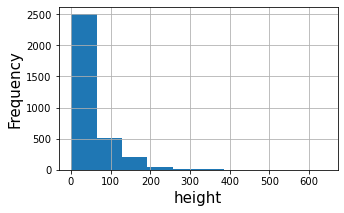

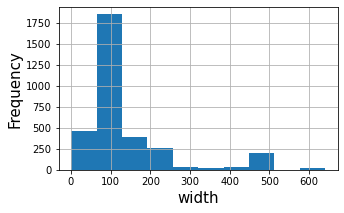

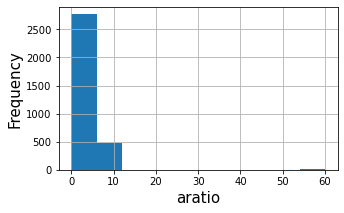

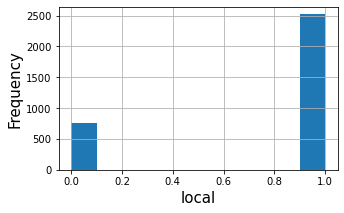

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

def hist_plot(df,a):
    df[a].hist(figsize = (5,3))
    plt.xlabel(a, fontsize = 15)
    plt.ylabel('Frequency',fontsize = 15)
    plt.tick_params(axis="x", labelsize=10)
    plt.tick_params(axis="y", labelsize=10)
    plt.grid(True)
    plt.show()

for i in sample_columns:
    hist_plot(internetAd, i)

### Target Variable

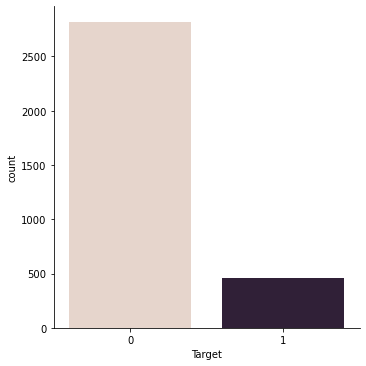

In [35]:
import seaborn as sns
sns.catplot(x="Target", kind="count", palette="ch:.1", data=internetAd)

Looking at the distribution of the `Target` column, we can see there is a class imbalance present.

## Question 2: Split dataset into training and test set

As it is possible to notice there is a wide variation across the different features. Therefore, I will normalize the features using MinMaxScalar method.

Also the dataset will be split into training and testing. The testing portion will not be touch but until the final model is decided/selected.

In [28]:
from sklearn.model_selection import train_test_split

columns_no_target = internetAd.columns.to_list()
columns_no_target.remove('Target')

X = internetAd[columns_no_target]
y = internetAd['Target']

X_train_original, X_test_final, y_train_original, y_test_final = train_test_split(X, y, test_size=0.2, random_state=42)

### A further split is used to obtain the `train` & `validation` set.

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X_train_original, y_train_original, test_size=0.2, random_state=42)

In [31]:
from sklearn.preprocessing import MinMaxScaler

#Minmax normalization
scaler = MinMaxScaler()
scaler.fit(X_train)

X_train_minmax_scaled = scaler.transform(X_train)
X_test_minmax_scaled = scaler.transform(X_test)

## Question 3: Train and evaluate a randomeforrest classifier using the following gridsearch parameters:
- "max_depth": [2, 4],
- "min_samples_split": [0.05, 0.1, 0.2]

In [37]:
parameters = {"max_depth": [2, 4],
              "min_samples_split": [0.05, 0.1, 0.2]}

rf_base = RandomForestClassifier()

dtc_grid = GridSearchCV(estimator = rf_base, param_grid = parameters,
                        cv = 10, verbose = 2, n_jobs = -1)
dtc_grid.fit(X_train_minmax_scaled, y_train)

Fitting 10 folds for each of 6 candidates, totalling 60 fits


GridSearchCV(cv=10, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [2, 4],
                         'min_samples_split': [0.05, 0.1, 0.2]},
             verbose=2)

In [38]:
y = dtc_grid.best_params_
y

{'max_depth': 4, 'min_samples_split': 0.1}

In [39]:
# make predictions with the trained random forest
test_z = dtc_grid.predict(X_test_minmax_scaled)
test_z_prob = dtc_grid.predict_proba(X_test_minmax_scaled)

In [43]:
def performance_values(X_test, y_test, lr):
    import sklearn.metrics
    from sklearn import preprocessing, metrics
    from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score
    
    y_pred = lr.predict(X_test)
    lr_acc = accuracy_score(y_test, y_pred)
    probs = lr.predict_proba(X_test)
    preds = probs[:,1]
    fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
    roc_auc = metrics.roc_auc_score(y_test, preds)
    return (fpr, tpr, lr_acc, roc_auc)

In [47]:
def ROC_curve(fpr,tpr,roc_auc):
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [46]:
fpr, tpr, rf_acc, roc_auc = performance_values(X_test_minmax_scaled, y_test, dtc_grid)
print("Accuracy: {}".format(rf_acc))
print("AUC: {}".format(roc_auc))

Accuracy: 0.8933333333333333
AUC: 0.9437758982800702


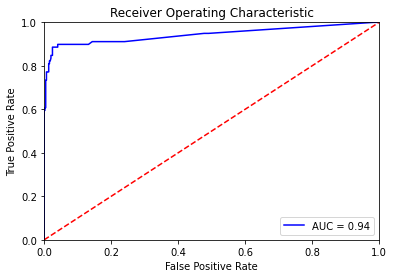

In [48]:
ROC_curve(fpr,tpr,roc_auc)

## Question 4: Train and evaluate a ExtraTrees classifier using the following gridsearch parameters:
- "max_depth": [2, 4],
- "min_samples_split": [0.05, 0.1, 0.2]

In [49]:
parameters = {"max_depth": [2, 4],
              "min_samples_split": [0.05, 0.1, 0.2]}

et_base = ExtraTreesClassifier()

et_grid = GridSearchCV(estimator = et_base, param_grid = parameters,
                        cv = 10, verbose = 2, n_jobs = -1)
et_grid.fit(X_train_minmax_scaled, y_train)

Fitting 10 folds for each of 6 candidates, totalling 60 fits


GridSearchCV(cv=10, estimator=ExtraTreesClassifier(), n_jobs=-1,
             param_grid={'max_depth': [2, 4],
                         'min_samples_split': [0.05, 0.1, 0.2]},
             verbose=2)

In [50]:
z = et_grid.best_params_
z

{'max_depth': 4, 'min_samples_split': 0.05}

In [51]:
# make predictions with the trained random forest
test_et = et_grid.predict(X_test_minmax_scaled)
test_et_prob = et_grid.predict_proba(X_test_minmax_scaled)

In [54]:
fpr, tpr, et_acc, roc_auc = performance_values(X_test_minmax_scaled, y_test, et_grid)
print("Accuracy: {}".format(et_acc))
print("AUC: {}".format(roc_auc))

Accuracy: 0.8895238095238095
AUC: 0.9273712890957597


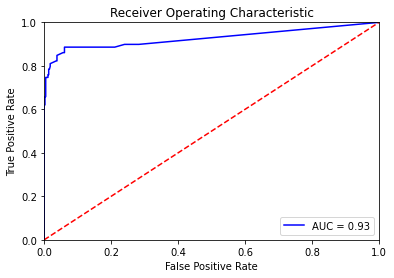

In [53]:
ROC_curve(fpr,tpr,roc_auc)

## Question 5: Train and evaluate a Gradient Boosted Trees classifier using the following gridsearch parameters:
- "max_depth": [2, 4],
- "min_samples_split": [0.05, 0.1, 0.2]

In [55]:
parameters = {"max_depth": [2, 4],
              "min_samples_split": [0.05, 0.1, 0.2]}

gbt_base = ExtraTreesClassifier()

gbt_grid = GridSearchCV(estimator = gbt_base, param_grid = parameters,
                        cv = 10, verbose = 2, n_jobs = -1)
gbt_grid.fit(X_train_minmax_scaled, y_train)

Fitting 10 folds for each of 6 candidates, totalling 60 fits


GridSearchCV(cv=10, estimator=ExtraTreesClassifier(), n_jobs=-1,
             param_grid={'max_depth': [2, 4],
                         'min_samples_split': [0.05, 0.1, 0.2]},
             verbose=2)

In [56]:
w = gbt_grid.best_params_
w

{'max_depth': 4, 'min_samples_split': 0.05}

In [57]:
# make predictions with the trained random forest
test_gbt = gbt_grid.predict(X_test_minmax_scaled)
test_gbt_prob = gbt_grid.predict_proba(X_test_minmax_scaled)

In [58]:
fpr, tpr, gbt_acc, roc_auc = performance_values(X_test_minmax_scaled, y_test, gbt_grid)
print("Accuracy: {}".format(gbt_acc))
print("AUC: {}".format(roc_auc))

Accuracy: 0.8914285714285715
AUC: 0.9384117613668616


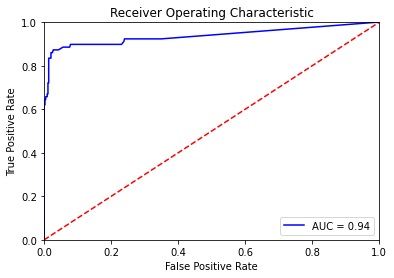

In [59]:
ROC_curve(fpr,tpr,roc_auc)

## [Bonus] Question 6: Which algorithm performed better and why?


## Question 7: Create a new text cell in your Notebook: Complete a 50-100 word summary (or short description of your thinking in applying this week's learning to the solution) of your experience in this assignment. Include: 
- What was your incoming experience with this model, if any? 
- what steps you took, what obstacles you encountered?
- how you link this exercise to real-world, machine learning problem-solving?
- What steps were missing? What else do you need to learn?